In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [29]:
epochs = 10
minibatch = 128
d = 2

train_dataset = torchvision.datasets.MNIST(root = './',
                                                  train = True,
                                                  download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.MNIST(root = './',
                                                 train = False,
                                                 download=True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))

In [32]:
n_classes = 10
# preprocess dataset 
for idx, (image, label) in enumerate(train_dataset):
    # binarize image
    image[image < 0.5] = 0
    image[image >= 0.5] = 1
    # one hot encode labels
    label_oh = np.zeros([1, n_classes])
    label_oh[0][label] = 1
    label_oh = torch.tensor(label_oh.astype('float32'))
    
for idx, (image, label) in enumerate(test_dataset):
    # # binarize image
    image[image < 0.5] = 0
    image[image >= 0.5] = 1
    # one hot encode labels
    label_oh = np.zeros([1, n_classes])
    label_oh[0][label] = 1
    label_oh = torch.tensor(label_oh.astype('float32'))

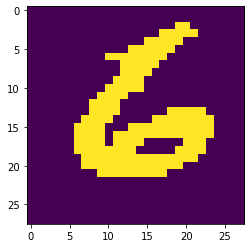

In [36]:
plt.imshow(image.view(28, 28).numpy())

In [28]:
class MaskConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, color_conditioning = False, conditional_size = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros(self.weight.size())) # Weight shape is same as tensor shape
        self.conditional_size = conditional_size
        assert mask_type in ['A', 'B'], "Unknown Mask Type"
        h =  self.kernel_size[0]
        w = self.kernel_size[1]
        
        # Creating masks for autoregressive properties
        self.mask[:, :, :h//2, :] = 1  # Mask type A 
        self.mask[:, :, h//2, :w//2 + (mask_type == 'B')] = 1 # Mask type B
        
        # Adding autoregressive property of color channels
        if color_conditioning:
            in_third, out_third = self.in_channels // 3, self.out_channels // 3
            if mask_type == 'B':
                self.mask[2*out_third:, :, h // 2, w // 2] = 1 # B has connections from R, G and B of input mask
                self.mask[out_third:2*out_third, :2*in_third, h // 2, w // 2] = 1 # G has connections from R and G
                self.mask[out_third:, in_third:, h // 2, w // 2] = 1 # R has connections only from R
            else:
                self.mask[out_third:2*out_third, :in_third, h // 2, w // 2] = 1  # G has connections from R
                self.mask[2*out_third:, :2*in_third, h // 2, w // 2] = 1 # B has connections from R and G
                
        if self.conditional_size:
            if len(self.conditional_size) == 1:
                self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
            else:
                self.cond_op = nn.Conv2d(conditional_size[0], self.out_channels, stride = 1,
                                         kernel_size = 3, padding = 1)
      
    def forward(self, x, cond = None):
        self.weight.data *= self.mask
        out = super(MaskConv2D, self).forward(x)
        if self.conditional_size:
            if len(self.conditional_size) == 1:
                out = out + self.cond_op(cond).view(x.shape[0], -1, 1, 1)
            else:
                out = out + self.cond_op(cond)
        return out

class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super(ResBlock, self).__init__()
        self.net = nn.ModuleList()
        self.net = self.net.extend([
            nn.ReLU(),
            MaskConv2D('B', in_channels, in_channels // 2, 1, 1, 1 // 2, **kwargs),
            nn.ReLU(),
            MaskConv2D('B', in_channels // 2, in_channels // 2, 7, 1,  7 // 2, **kwargs),
            nn.ReLU(),
            MaskConv2D('B', in_channels // 2, in_channels, 1, 1, 1 // 2, **kwargs),
        ])
    def forward(self, x, cond = None):
        out = x
        for layer in self.net:
            if isinstance(layer, MaskConv2D):
                out = layer(out, cond = cond)
            else:
                out = layer(out)
        return x + out

In [44]:
class Conditional_PixelCNN(nn.Module):
    def __init__(self, input_shape, channels, colors, no_of_layers,
                 color_conditioning, use_ResBlock, conditional_size = None, device = None):
        super(Conditional_PixelCNN, self).__init__()
        self.input_shape = input_shape
        self.device = device
        self.channels = channels
        self.color_channels = colors
        self.color_conditioning = color_conditioning
        self.conditional_size = conditional_size
        
        # Define kwargs based on input
        kwargs = dict(
            color_conditioning = self.color_conditioning,
            conditional_size = self.conditional_size
        )
        
        # Initialize block function to be used repeatedly
        if use_ResBlock:
            block = lambda: ResBlock(channels, **kwargs)    
        else:
            block = lambda: MaskConv2D('B', channels, channels,
                                       kernel_size = 7, padding = 7 // 2,
                                       **kwargs)
        
        # 7 x 7 Conv2D operation using Type A Mask
        kernel_size = 7
        self.net = nn.ModuleList()
        self.net.extend([MaskConv2D('A', input_shape[0], channels,
                                    kernel_size = 7, padding = 7 // 2,
                                    **kwargs)])
        
        # 5 7 x 7 Conv2D operation using Type B Mask
        for _ in range(no_of_layers):
            self.net.extend([nn.ReLU(),
                                nn.BatchNorm2d(channels),
                                block(),])
        
        # 2 1 x 1 Conv2D operation using Type B Mask
        self.net.extend([nn.ReLU(),
                            nn.BatchNorm2d(channels),
                            MaskConv2D('B', channels, channels, 1, 1, **kwargs),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels),
                            MaskConv2D('B', channels, self.color_channels * self.input_shape[0],
                                       1, 1, **kwargs)])
        
#         self.net = nn.ModuleList(self.layers)
        
        if self.conditional_size:
            if len(self.conditional_size) == 1:
                self.cond_op = lambda x: x  # identity
            else:
                self.cond_op = nn.Sequential(
            F.relu(nn.Conv2d(1, 64, 3, padding=1)),
            F.relu(nn.Conv2d(64, 64, 3, padding=1)),
            F.relu(nn.Conv2d(64, 64, 3, padding=1)),
        )

    def forward(self, x, cond = None):
        batch_size = x.shape[0]
        out = (x.float() / (self.color_channels - 1) - 0.5) / 0.5
        if self.conditional_size:
            cond = self.cond_op(cond)
        for layer in self.net:
            if isinstance(layer, MaskConv2D) or isinstance(layer, ResBlock):
                out = layer(out, cond)
            else:
                out = layer(out)
            
        if self.color_conditioning:
            return out.view(batch_size, self.input_shape[0], self.color_channels,
                          *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
        else:
            return out.view(batch_size, self.color_channels, *self.input_shape)
    
    def loss(self, x, cond = None):
        return F.cross_entropy(self(x, cond = cond), x.long())
 
    def get_samples(self, n, cond=None):
        samples = torch.zeros([n, *self.input_shape]).to(self.device)
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.input_shape[0]):
                        out = self(samples, cond=cond)[:, :, k, r, c]
                        probs = F.softmax(out, dim = 1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [8]:
def train(model, trainloader, optimizer, device):
    model.train()
    train_loss = []
    for idx, (img, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        loss = model.loss(img.to(device), cond = labels)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    return train_loss

def evaluate(model, testloader, optimizer, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for idx, (img, labels) in enumerate(testloader):
            loss = model.loss(img.to(device)).item()
            test_loss += loss * img.shape[0]
        test_loss /= len(testloader.dataset) # dividing by batch size
    return test_loss

In [46]:
epochs = 2
minibatch = 128
d = 2

train_loss = np.zeros([minibatch * epochs, 1])
test_loss = np.zeros([epochs, 1])

trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size = minibatch, shuffle = True)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size = minibatch, shuffle = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conditional_PixelCNN((1, 28, 28),
                             channels = 64,
                             colors = 2, # binarized image
                             no_of_layers = 3,
                             color_conditioning=False,
                             use_ResBlock = True,
                             conditional_size = None,
                             device = device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.02)

train_loss = []
test_loss = []

for epoch in range(epochs):
    print ("Epoch No. " + str(epoch))
    train_loss.extend(train(model, trainLoader, optimizer, device))
    test_loss.append(evaluate(model, testLoader, optimizer, device)) 

Epoch No. 0
Epoch No. 1


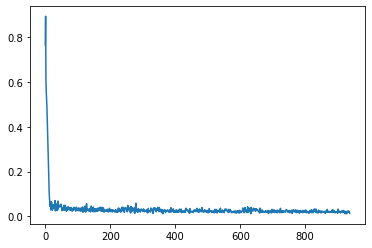

In [47]:
plt.plot(train_loss)
plt.show()

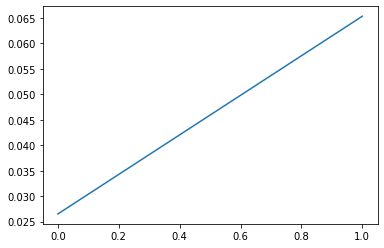

In [48]:
plt.plot(test_loss)
plt.show()

In [49]:
n_classes = 10
cond = torch.arange(n_classes).unsqueeze(1).repeat(1, 25 // n_classes).view(-1).long()
one_hot = torch.FloatTensor(cond.shape[0], n_classes)
one_hot.zero_()
one_hot.scatter_(1, cond.unsqueeze(1), 1)
one_hot = one_hot.to(device)

s = model.get_samples(25)

In [50]:
np.unique(s[1])

array([0.], dtype=float32)

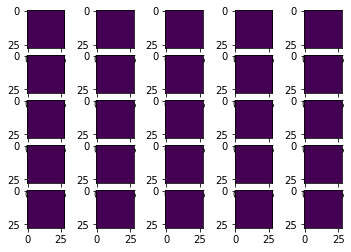

In [43]:
size = 5
fig, axs = plt.subplots(size, size)
for i in range(0, size):
    for j in range(0, size):
        axs[i, j].imshow(s[size * i + j].reshape(28, 28))